# Comparison with BHPWave in the Circular Orbit Limit

#### Current contributers to notebook: Philip Lynch

"Comparison plot with bhpwave in the circular limit. (Perhaps mismatches for different spins?)"

__NB: Need to perform the rescaling due to different definitions of G!__

I have also included a comparison with ScwharzEccFlux in the a = 0 limit.

## Import Packages

In [1]:
from bhpwave.waveform import KerrWaveform, KerrFrequencyWaveform
import matplotlib.pyplot as plt
import numpy as np

from few.trajectory.inspiral import EMRIInspiral
from few.trajectory.ode import SchwarzEccFlux, KerrEccEqFlux, PN5

from few.amplitude.romannet import RomanAmplitude
from few.amplitude.ampinterp2d import AmpInterpSchwarzEcc

from few.utils.utility import ( 
    get_mismatch, 
    get_fundamental_frequencies, 
    get_separatrix, 
    get_mu_at_t, 
    get_p_at_t, 
    get_kerr_geo_constants_of_motion,
    ELQ_to_pex,
    )

from few.utils.pn_map import (
    xI_to_Y,
    Y_to_xI
)
from few.utils.ylm import GetYlms
from few.utils.modeselector import ModeSelector
from few.summation.interpolatedmodesum import CubicSplineInterpolant, InterpolatedModeSum
from few.summation.directmodesum import DirectModeSum
from few.summation.aakwave import AAKSummation
from few.utils.constants import *

from few.waveform import (
    FastSchwarzschildEccentricFlux, 
    SlowSchwarzschildEccentricFlux,
    FastKerrEccentricEquatorialFlux, 
    Pn5AAKWaveform,
    GenerateEMRIWaveform
)
from few.waveform.base import SphericalHarmonicWaveformBase, AAKWaveformBase, ABC

%matplotlib inline

In [6]:
use_gpu = False

# keyword arguments for inspiral generator (EMRIInspiral)
inspiral_kwargs={
        "DENSE_STEPPING": 0,  # we want a sparsely sampled trajectory
        "buffer_length": int(1e3),  # all of the trajectories will be well under len = 1000
    }

# keyword arguments for inspiral generator (RomanAmplitude)
amplitude_kwargs = {
    "buffer_length": int(1e3),  # all of the trajectories will be well under len = 1000
    "use_gpu": use_gpu  # GPU is available in this class
}

# keyword arguments for Ylm generator (GetYlms)
Ylm_kwargs = {
    "assume_positive_m": False  # if we assume positive m, it will generate negative m for all m>0
}

# keyword arguments for summation generator (InterpolatedModeSum)
sum_kwargs = {
    "use_gpu": use_gpu,  # GPU is available for this type of summation
    "pad_output": False,
}


few = FastKerrEccentricEquatorialFlux(
    inspiral_kwargs=inspiral_kwargs,
    amplitude_kwargs=amplitude_kwargs,
    Ylm_kwargs=Ylm_kwargs,
    sum_kwargs=sum_kwargs,
    use_gpu=use_gpu,
)

fewSchwarz = FastSchwarzschildEccentricFlux(
    inspiral_kwargs=inspiral_kwargs,
    amplitude_kwargs=amplitude_kwargs,
    Ylm_kwargs=Ylm_kwargs,
    sum_kwargs=sum_kwargs,
    use_gpu=use_gpu,
)

BHPWave = KerrWaveform()

## Examining Single Waveforms

In [178]:
M = 1e6  # primary mass in solar masses
mu = 1e1 # secondary mass in solar masses
a = -0.9 # dimensionless spin of the primary
p0 = 15 # initial semi-latus rectum
e0 = 0.0 # eccentricity is ignored for circular orbits
x0 = 1.0  # inclination is ignored for circular orbits
qK = 0.8  # polar angle of Kerr spin angular momentum
phiK = 0.2  # azimuthal angle of Kerr spin angular momentum
theta = np.pi/3  # polar viewing angle
phi = np.pi/4  # azimuthal viewing angle
Phi_phi0 = 0.0 # initial azimuthal position of the secondary
Phi_theta0 = 0. # ignored for circular orbits
Phi_r0 = 0.0 # ignored for circular orbits
dt = 10.0  # time steps in seconds
T = 1.0  # waveform duration in years


In [181]:
# Get the desired value of p so that we can always have a 4 year waveform
traj_module = EMRIInspiral(func=KerrEccEqFlux)

traj_args = [M, mu, abs(a), e0, np.sign(a) * x0]
traj_kwargs = {}
index_of_p = 3

t_out = 1
# run trajectory
p_new = get_p_at_t(
    traj_module,
    t_out,
    traj_args,
    index_of_p=3,
    index_of_a=2,
    index_of_e=4,
    index_of_x=5,
    traj_kwargs={},
    xtol=2e-12,
    rtol=8.881784197001252e-16,
    bounds=None,
)

print('p0 = {} will create a waveform that is {} years long, given the other input parameters.'.format(p_new, t_out))

p0 = 14.08920510380393 will create a waveform that is 1 years long, given the other input parameters.


In [182]:
fewWF = few(M, mu,abs(a),p_new, e0,np.sign(a) * x0, theta, phi, dt=dt, T=t_out)  #  defaults to dt = 10.0 for max T = 1.0 year

In [183]:
BHPWF = BHPWave.source_frame(M, mu, a, p_new, theta, phi, Phi_phi0, dt=dt, T=t_out)

In [184]:
(len(fewWF),len(BHPWF) )

(3155815, 3155815)

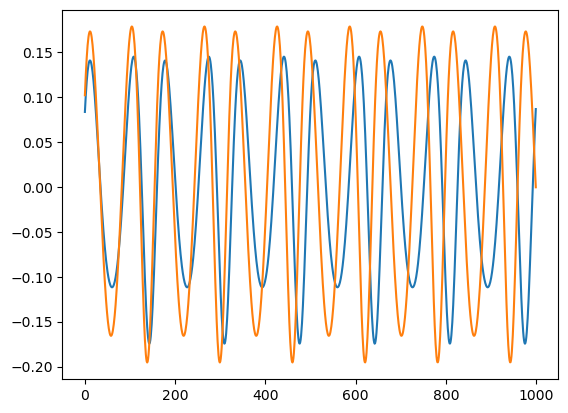

In [185]:
t = np.arange(len(fewWF)) * dt

plt.plot(fewWF.real[:1000])

t2 = np.arange(len(BHPWF))*dt
plt.plot(BHPWF.real[:1000])

In [ ]:
plt.plot()

In [186]:
mm = get_mismatch(fewWF, BHPWF)
if(mm > 1.):
    mm = 1 - (mm-1)

mm


np.float64(0.9912710864328971)

## Multiple Inspirals

So the plan is to again iterate through a list of spin values from -0.99 to 0.99 and calculate the mistmatch at each before plotting. 
We can also repeat this proceedure for a = 0 and vary ecentricity. 

In [26]:
spins = np.array([-0.99,-0.9,-0.8,-0.7,-0.6,-0.5,-0.4,-0.3,-0.2,-0.1,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.99])
mms = np.zeros(len(spins))
traj_module = EMRIInspiral(func=KerrEccEqFlux)

M = 1e6  # primary mass in solar masses
mu = 1e1 # secondary mass in solar masses
a = 0.9 # dimensionless spin of the primary
p0 = 12 # initial semi-latus rectum
e0 = 0.0 # eccentricity is ignored for circular orbits
x0 = 1  # inclination is ignored for circular orbits
qK = 0.8  # polar angle of Kerr spin angular momentum
phiK = 0.2  # azimuthal angle of Kerr spin angular momentum
theta = np.pi/3  # polar viewing angle
phi = np.pi/4  # azimuthal viewing angle
Phi_phi0 = 0.0 # initial azimuthal position of the secondary
Phi_theta0 = 0. # ignored for circular orbits
Phi_r0 = 0.0 # ignored for circular orbits
dt = 10.0  # time steps in seconds
T = 1.0  # waveform duration in years



In [27]:
a = -0.9
x0 = -1. if a<0 else 1.
x0

-1.0

In [28]:


for i in range(len(spins)):
    a = spins[i]
    x0 = -1. if a<0 else 1.
    print(a)
    traj_args = [M, mu, abs(a), e0, x0]
    traj_kwargs = {}
    index_of_p = 3

    # run trajectory
    p_new = get_p_at_t(
        traj_module,
        T,
        traj_args,
        index_of_p=3,
        index_of_a=2,
        index_of_e=4,
        index_of_x=5,
        traj_kwargs={},
        xtol=2e-12,
        rtol=8.881784197001252e-16,
        bounds=None,
    )
    
    fewWF = few(M, mu,abs(a),p_new, e0,x0, theta, phi, dt=dt, T=T)
    BHPWF = BHPWave.source_frame(M, mu, a, p_new, theta, phi, Phi_phi0, dt=dt, T=T)
    mm = get_mismatch(fewWF, BHPWF)
    if(mm > 1.):
        mm = 1 - (mm-1)
    mms[i] = mm


-0.99
-0.9
-0.8
-0.7
-0.6
-0.5
-0.4
-0.3
-0.2
-0.1
0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
0.99


/Users/philip/opt/anaconda3/envs/few_env/lib/python3.12/site-packages/few/utils/utility.py:103: UserWarning: The two time series are not the same length (3155815 vs 3011366). The calculation will run with length 3011366 starting at index 0 for both arrays.
  warnings.warn(


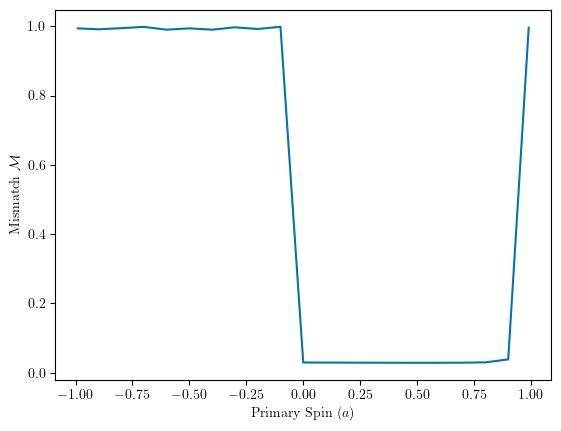

In [29]:
from seaborn import color_palette
plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Computer Modern"]

# seaborn colorblind palette
cpal = color_palette("colorblind")

plt.plot(spins,mms,color=cpal[0],rasterized=True)
plt.xlabel(r'Primary Spin $(a)$')
plt.ylabel(r'Mismatch $\mathcal{M}$')
plt.savefig("5-3a-ComparisonWithBHPWave.pdf")

## Examining a = 0 limit against Schwarzschild

In [7]:
M = 1e6  # primary mass in solar masses
mu = 1e1 # secondary mass in solar masses
a = 0.0 # dimensionless spin of the primary
p0 = 15 # initial semi-latus rectum
e0 = 0.5 # eccentricity
x0 = 1.0  # inclination is ignored for equatorial orbits
qK = 0.8  # polar angle of Kerr spin angular momentum
phiK = 0.2  # azimuthal angle of Kerr spin angular momentum
theta = np.pi/3  # polar viewing angle
phi = np.pi/4  # azimuthal viewing angle
Phi_phi0 = 0.0 # initial azimuthal position of the secondary
Phi_theta0 = 0. # ignored for circular orbits
Phi_r0 = 0.0 # ignored for circular orbits
dt = 10.0  # time steps in seconds
T = 1.0  # waveform duration in years

In [8]:
# Get the desired value of p so that we can always have a 4 year waveform
traj_module = EMRIInspiral(func=KerrEccEqFlux)

traj_args = [M, mu, abs(a), e0, x0]
traj_kwargs = {}
index_of_p = 3

t_out = 4
# run trajectory
p_new = get_p_at_t(
    traj_module,
    t_out,
    traj_args,
    index_of_p=3,
    index_of_a=2,
    index_of_e=4,
    index_of_x=5,
    traj_kwargs={},
    xtol=2e-12,
    rtol=8.881784197001252e-16,
    bounds=None,
)

print('p0 = {} will create a waveform that is {} years long, given the other input parameters.'.format(p_new, t_out))

p0 = 11.937769112341549 will create a waveform that is 4 years long, given the other input parameters.


In [9]:
kerrWF = few(M, mu,a,p_new, e0,x0, theta, phi, dt=dt, T=t_out)  #  defaults to dt = 10.0 for max T = 1.0 year

In [10]:
schwarzWF = fewSchwarz(M, mu,p_new, e0,x0, theta, phi, dt=dt, T=t_out)  #  defaults to dt = 10.0 for max T = 1.0 year

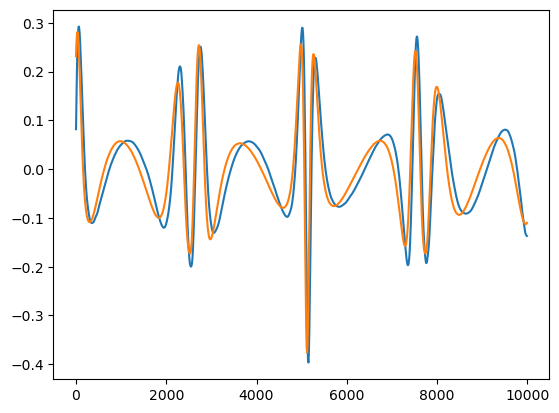

In [13]:
t1 = np.arange(len(kerrWF))*dt
plt.plot(t1[:1000],schwarzWF.real[:1000])

t2 = np.arange(len(kerrWF))*dt
plt.plot(t2[:1000],kerrWF.real[:1000])

In [14]:
mm = get_mismatch(schwarzWF, kerrWF)
mm

np.float64(0.07278128027023056)

In [15]:
es = np.arange(0,0.75,0.05)
mms = np.zeros(len(es))
traj_module = EMRIInspiral(func=KerrEccEqFlux)


M = 1e6  # primary mass in solar masses
mu = 1e1 # secondary mass in solar masses
a = 0.0 # dimensionless spin of the primary
p0 = 15 # initial semi-latus rectum
e0 = 0.5 # eccentricity
x0 = 1.0  # inclination is ignored for equatorial orbits
qK = 0.8  # polar angle of Kerr spin angular momentum
phiK = 0.2  # azimuthal angle of Kerr spin angular momentum
theta = np.pi/3  # polar viewing angle
phi = np.pi/4  # azimuthal viewing angle
Phi_phi0 = 0.0 # initial azimuthal position of the secondary
Phi_theta0 = 0. # ignored for circular orbits
Phi_r0 = 0.0 # ignored for circular orbits
dt = 10.0  # time steps in seconds
T = 4.0  # waveform duration in years

In [16]:
for i in range(len(es)):
    print(es[i])
    traj_args = [M, mu, abs(a), es[i], x0]
    traj_kwargs = {}
    index_of_p = 3


    t_out = 4
    # run trajectory
    p_new = get_p_at_t(
        traj_module,
        t_out,
        traj_args,
        index_of_p=3,
        index_of_a=2,
        index_of_e=4,
        index_of_x=5,
        traj_kwargs={},
        xtol=2e-12,
        rtol=8.881784197001252e-16,
        bounds=None,
    )
    kerrWF = few(M, mu,a,p_new, es[i],x0, theta, phi, dt=dt, T=t_out)  #  defaults to dt = 10.0 for max T = 1.0 year
    schwarzWF = fewSchwarz(M, mu,p_new, es[i],x0, theta, phi, dt=dt, T=t_out)  #  defaults to dt = 10.0 for max T = 1.0 year
    mm = get_mismatch(kerrWF, schwarzWF)
    if(mm > 1.):
        mm = 1 - (mm-1)
    mms[i] = mm
    print(mms[i])


0.0


/Users/philip/opt/anaconda3/envs/few_env/lib/python3.12/site-packages/few/utils/utility.py:103: UserWarning: The two time series are not the same length (12623260 vs 12621829). The calculation will run with length 12621829 starting at index 0 for both arrays.
  warnings.warn(


0.16553788612808185
0.05


/Users/philip/opt/anaconda3/envs/few_env/lib/python3.12/site-packages/few/utils/utility.py:103: UserWarning: The two time series are not the same length (12623260 vs 12621378). The calculation will run with length 12621378 starting at index 0 for both arrays.
  warnings.warn(


0.16317217022360408
0.1


/Users/philip/opt/anaconda3/envs/few_env/lib/python3.12/site-packages/few/utils/utility.py:103: UserWarning: The two time series are not the same length (12623260 vs 12621099). The calculation will run with length 12621099 starting at index 0 for both arrays.
  warnings.warn(


0.1632470775359648
0.15000000000000002


/Users/philip/opt/anaconda3/envs/few_env/lib/python3.12/site-packages/few/utils/utility.py:103: UserWarning: The two time series are not the same length (12623260 vs 12620881). The calculation will run with length 12620881 starting at index 0 for both arrays.
  warnings.warn(


0.1642828814758993
0.2


/Users/philip/opt/anaconda3/envs/few_env/lib/python3.12/site-packages/few/utils/utility.py:103: UserWarning: The two time series are not the same length (12623260 vs 12620692). The calculation will run with length 12620692 starting at index 0 for both arrays.
  warnings.warn(


0.16764881951747435
0.25


/Users/philip/opt/anaconda3/envs/few_env/lib/python3.12/site-packages/few/utils/utility.py:103: UserWarning: The two time series are not the same length (12623260 vs 12620521). The calculation will run with length 12620521 starting at index 0 for both arrays.
  warnings.warn(


0.17071015583128601
0.30000000000000004


/Users/philip/opt/anaconda3/envs/few_env/lib/python3.12/site-packages/few/utils/utility.py:103: UserWarning: The two time series are not the same length (12623260 vs 12620358). The calculation will run with length 12620358 starting at index 0 for both arrays.
  warnings.warn(


0.17609592822923414
0.35000000000000003


/Users/philip/opt/anaconda3/envs/few_env/lib/python3.12/site-packages/few/utils/utility.py:103: UserWarning: The two time series are not the same length (12623260 vs 12620199). The calculation will run with length 12620199 starting at index 0 for both arrays.
  warnings.warn(


0.1578605052305292
0.4


/Users/philip/opt/anaconda3/envs/few_env/lib/python3.12/site-packages/few/utils/utility.py:103: UserWarning: The two time series are not the same length (12623260 vs 12620041). The calculation will run with length 12620041 starting at index 0 for both arrays.
  warnings.warn(


0.12903756298647495
0.45


/Users/philip/opt/anaconda3/envs/few_env/lib/python3.12/site-packages/few/utils/utility.py:103: UserWarning: The two time series are not the same length (12623260 vs 12619880). The calculation will run with length 12619880 starting at index 0 for both arrays.
  warnings.warn(


0.0712869181669864
0.5


/Users/philip/opt/anaconda3/envs/few_env/lib/python3.12/site-packages/few/utils/utility.py:103: UserWarning: The two time series are not the same length (12623260 vs 12619714). The calculation will run with length 12619714 starting at index 0 for both arrays.
  warnings.warn(


0.07278128027023056
0.55


/Users/philip/opt/anaconda3/envs/few_env/lib/python3.12/site-packages/few/utils/utility.py:103: UserWarning: The two time series are not the same length (12623260 vs 12619538). The calculation will run with length 12619538 starting at index 0 for both arrays.
  warnings.warn(


0.4481544432018256
0.6000000000000001


/Users/philip/opt/anaconda3/envs/few_env/lib/python3.12/site-packages/few/utils/utility.py:103: UserWarning: The two time series are not the same length (12623260 vs 12619345). The calculation will run with length 12619345 starting at index 0 for both arrays.
  warnings.warn(


0.6941546020682441
0.65


/Users/philip/opt/anaconda3/envs/few_env/lib/python3.12/site-packages/few/utils/utility.py:103: UserWarning: The two time series are not the same length (12623260 vs 12619114). The calculation will run with length 12619114 starting at index 0 for both arrays.
  warnings.warn(


0.9565545656229344
0.7000000000000001


/Users/philip/opt/anaconda3/envs/few_env/lib/python3.12/site-packages/few/utils/utility.py:103: UserWarning: The two time series are not the same length (12623260 vs 12617019). The calculation will run with length 12617019 starting at index 0 for both arrays.
  warnings.warn(


0.9909489661972013


## Plotting Spin = 0 Results

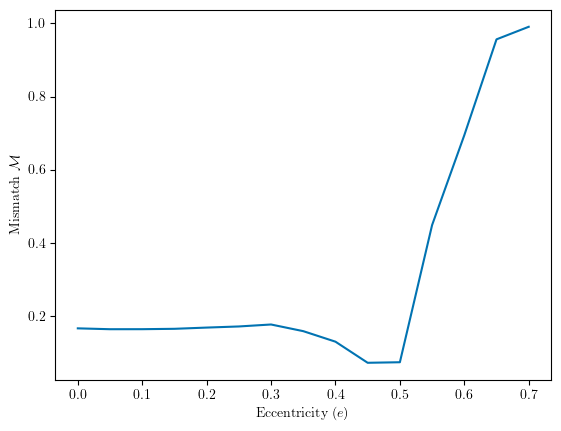

In [24]:
from seaborn import color_palette
plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Computer Modern"]

# seaborn colorblind palette
cpal = color_palette("colorblind")

plt.plot(es,mms,color=cpal[0],rasterized=True)
plt.xlabel(r'Eccentricity $(e)$')
plt.ylabel(r'Mismatch $\mathcal{M}$')

plt.savefig("5-3b-ComparisonWithSchwarzEcc.pdf")